In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import Dataset
import csv
from PIL import Image
import re
from torchsummary import summary
from piqa import SSIM
import torchvision.transforms.functional as TF
cudnn.benchmark = True
plt.ion()

Dataset

In [2]:
class CustomDataset(Dataset):
    def __init__(self, path, transform=None):
        super().__init__()
        self.transform = transform
        self.main_dir = os.path.join(path)
        self.all_imgs = sorted(os.listdir(self.main_dir), key=lambda s: int(re.search(r'\d+', s).group()))
        
    def __len__(self):
        return len(self.all_imgs)
    
    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

Device

In [3]:
#apple
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
#windows
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Load Data

In [40]:

train_data_transforms =  transforms.Compose([
        transforms.Resize((512,512)),
        #transforms.AugMix(),
        transforms.ToTensor(),
        #transforms.Normalize((0.3876, 0.2773, 0.2424), 
        #                      (0.2055, 0.1425, 0.1162))
    ])


data_transforms =  transforms.Compose([
        transforms.Resize((512,512)),
        transforms.ToTensor(),
       # transforms.Normalize((0.3876, 0.2773, 0.2424), 
       #                       (0.2055, 0.1425, 0.1162))
    ])
directory = os.getcwd()
data_dir = r'E:\Master Mechatronics\Projects\anomaly-detection\data\transistor\train\good'
train_dataset = CustomDataset(data_dir,train_data_transforms)
test_dataset = CustomDataset(r'E:\Master Mechatronics\Projects\anomaly-detection\data\transistor\test\mix',data_transforms)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.8, 0.2])
train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size=1,
                                             shuffle=False, num_workers=0)

val_dataloader =  torch.utils.data.DataLoader(val_dataset, batch_size=1,
                                             shuffle=False, num_workers=0)

test_dataloader =  torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                             shuffle=False, num_workers=0)

print(len(train_dataloader),len(val_dataloader),len(test_dataloader))

171 42 40


View Data

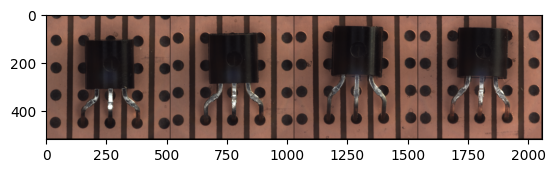

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    #mean = torch.tensor([0.3876, 0.2773, 0.2424], dtype=torch.float32)
    #std = torch.tensor([0.2055, 0.1425, 0.1162], dtype=torch.float32)
    #inp = TF.normalize(inp,(-mean / std).tolist(), (1.0 / std).tolist())
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of  data
inputs = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

Datasets & DataLoaders

In [41]:
image_datasets = {'train': train_dataset }
dataloaders = {'train': train_dataloader}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train']}


In [11]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

mean, std = get_mean_and_std(train_dataloader)
print("mean and std: \n", mean, std)

mean and std: 
 tensor([0.3862, 0.2764, 0.2416]) tensor([0.2048, 0.1420, 0.1157])


mean and std: 
 tensor([0.3876, 0.2773, 0.2424]) tensor([0.2055, 0.1425, 0.1162])

In [ ]:
with torch.no_grad():
    for image_batch in test_dataloader:
        # out = torchvision.utils.make_grid(image_batch)

        # imshow(out)
        img = image_batch.mean([0,2,3])
        print((img-mean)/std)

tensor([0.1272, 0.1086, 0.0908])
tensor([-0.0358, -0.0401, -0.0577])
tensor([0.0593, 0.0678, 0.0496])
tensor([-0.0777,  0.0016, -0.0507])
tensor([-0.0434, -0.0030,  0.0130])
tensor([0.0114, 0.0796, 0.0156])
tensor([0.0517, 0.0181, 0.0124])
tensor([0.0708, 0.0535, 0.0357])
tensor([0.5715, 0.5082, 0.4855])
tensor([-0.0753, -0.0036, -0.0596])
tensor([0.0797, 0.0689, 0.0340])
tensor([ 0.0229,  0.0042, -0.0276])
tensor([0.5765, 0.5201, 0.5098])
tensor([-0.0606,  0.0177, -0.0194])
tensor([-0.0264, -0.0186, -0.0315])
tensor([ 0.0230, -0.0014, -0.0205])
tensor([0.1133, 0.1028, 0.0887])
tensor([0.0393, 0.0557, 0.0615])
tensor([-0.0274,  0.0427, -0.0030])
tensor([0.0387, 0.0226, 0.0070])
tensor([0.0953, 0.0940, 0.1037])
tensor([-0.0150, -0.0287, -0.0337])
tensor([0.0454, 0.0440, 0.0240])
tensor([0.0550, 0.0300, 0.0167])
tensor([0.0354, 0.0334, 0.0523])
tensor([-0.0394, -0.0501, -0.0482])
tensor([0.0825, 0.0691, 0.0784])
tensor([0.1189, 0.1054, 0.0748])
tensor([ 0.0958,  0.0250, -0.0535])
tensor(

Encoder

In [12]:
class AutoEncoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(256),
            nn.Flatten(),
            nn.Linear(256*13*13, 256),#13*13  #29*29
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(True),
            nn.Linear(64, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(True),
            nn.Linear(16, 2)
        )    
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(True),
            nn.Linear(16, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(True),
            nn.Linear(64, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 256*13*13),
            nn.BatchNorm1d(256*13*13),
            nn.Unflatten(dim=1, unflattened_size=(256, 13, 13)),
            nn.ConvTranspose2d(256, 128, 4, 1, 0, bias=True),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=True),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=True),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 4, 2, 1, bias=True),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 4, 2, 1, bias=True),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, 4, 2, 1, bias=True),
            nn.ReLU(True)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        x = self.encoder(x)
        return x
    

In [13]:
testModel = AutoEncoder()
summary(testModel.to(device), (3, 512, 512),4)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [4, 8, 256, 256]             392
       BatchNorm2d-2           [4, 8, 256, 256]              16
              ReLU-3           [4, 8, 256, 256]               0
            Conv2d-4          [4, 16, 128, 128]           2,064
       BatchNorm2d-5          [4, 16, 128, 128]              32
              ReLU-6          [4, 16, 128, 128]               0
            Conv2d-7            [4, 32, 64, 64]           8,224
       BatchNorm2d-8            [4, 32, 64, 64]              64
              ReLU-9            [4, 32, 64, 64]               0
           Conv2d-10            [4, 64, 32, 32]          32,832
      BatchNorm2d-11            [4, 64, 32, 32]             128
             ReLU-12            [4, 64, 32, 32]               0
           Conv2d-13           [4, 128, 16, 16]         131,200
      BatchNorm2d-14           [4, 128,

Model, Loss & Optimizer

In [27]:
torch.manual_seed(0)

## piqa ssim
class SSIMLoss(SSIM):
    def forward(self, x, y):
        return 1. - super().forward(x, y)

ssimloss = SSIMLoss().to(device)

lr= 0.001
num_epochs = 40
mseloss = torch.nn.MSELoss()
loss = torch.nn.L1Loss()
model = AutoEncoder()
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=num_epochs * len(train_dataloader),
      eta_min= 1e-6/lr)

model.to(device)
torch.set_printoptions(threshold=10_000)

Train

In [15]:
def train_epoch(model, device, dataloader, loss_fn, optimizer,scheduler):

    model.train()
    train_loss = []
    for image_batch in dataloader: 
        image_batch = image_batch.to(device)
        decoded_data = model(image_batch)
        # # max value 1 ------ ssimloss
        # dd = decoded_data.clone()
        # dd[decoded_data>=1]=1
        # loss = loss_fn(decoded_data, image_batch) + ssimloss(image_batch,dd)
        loss = loss_fn(decoded_data, image_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        #print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

Validation Test

In [16]:
def test_epoch(model, device, dataloader, loss_fn):
    model.eval()
    with torch.no_grad():
        conc_out = []
        conc_label = []
        for image_batch in dataloader:
            image_batch = image_batch.to(device)
            decoded_data = model(image_batch)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

Plot Output

In [17]:
def plot_ae_outputs(model,n=10):
  # inputs = next(iter(val_dataloader))
  # out = torchvision.utils.make_grid(inputs)
  # imshow(out)
  img = inputs.to(device)
  model.eval()
  with torch.no_grad():
      rec_img  = model(img)
  rec_img = rec_img.cpu()
  rec_out =  torchvision.utils.make_grid(rec_img)
  imshow(rec_out)

Training


 EPOCH 1/50 	 train loss 0.18001098930835724 	 val loss 0.15768973529338837


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


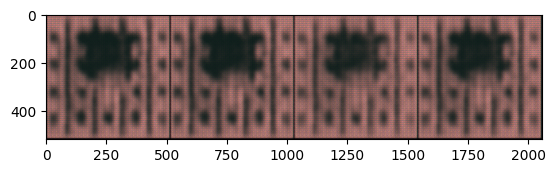


 EPOCH 2/50 	 train loss 0.08263494074344635 	 val loss 0.07510419934988022


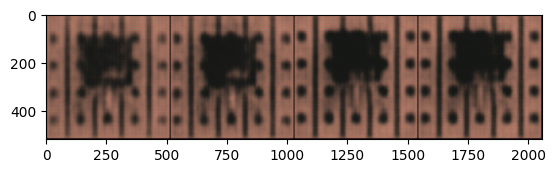


 EPOCH 3/50 	 train loss 0.057995785027742386 	 val loss 0.057726889848709106


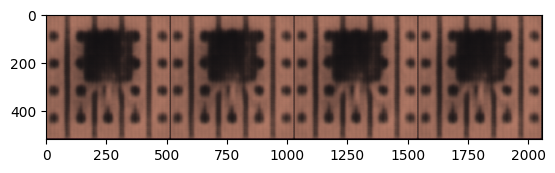


 EPOCH 4/50 	 train loss 0.054076023399829865 	 val loss 0.05734541267156601


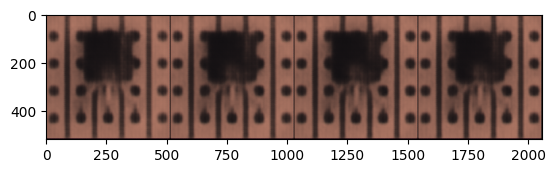


 EPOCH 5/50 	 train loss 0.05345779284834862 	 val loss 0.057607632130384445


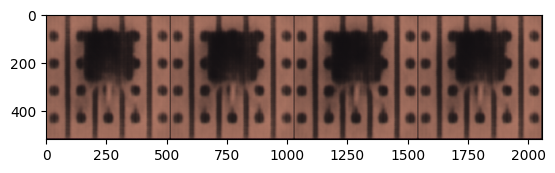


 EPOCH 6/50 	 train loss 0.0519491471350193 	 val loss 0.05665504187345505


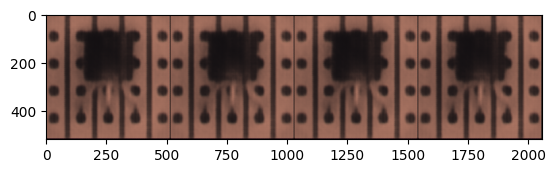


 EPOCH 7/50 	 train loss 0.05051933974027634 	 val loss 0.05230030044913292


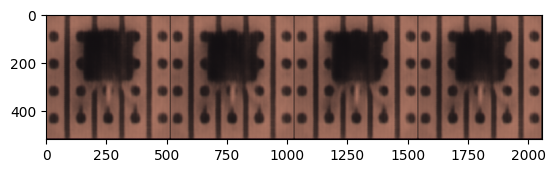


 EPOCH 8/50 	 train loss 0.04967837408185005 	 val loss 0.05232411250472069


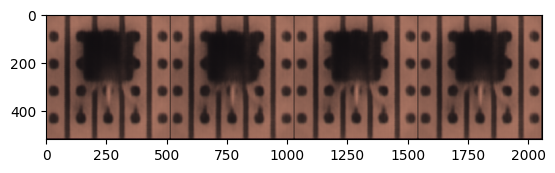


 EPOCH 9/50 	 train loss 0.04885692521929741 	 val loss 0.05386725068092346


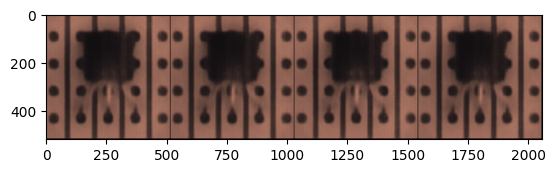


 EPOCH 10/50 	 train loss 0.04970839247107506 	 val loss 0.050736863166093826


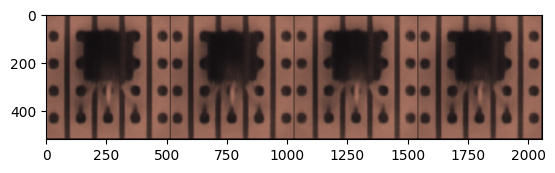


 EPOCH 11/50 	 train loss 0.04883282259106636 	 val loss 0.050634972751140594


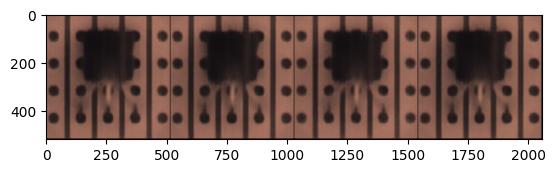


 EPOCH 12/50 	 train loss 0.04849175363779068 	 val loss 0.051654454320669174


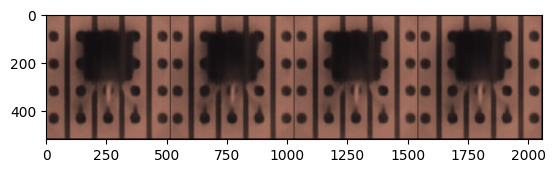


 EPOCH 13/50 	 train loss 0.04871591925621033 	 val loss 0.050023119896650314


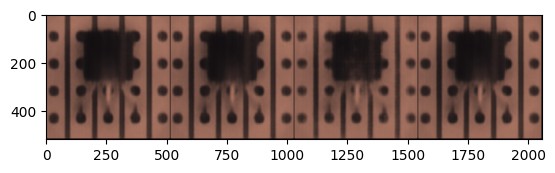


 EPOCH 14/50 	 train loss 0.048186544328927994 	 val loss 0.049610599875450134


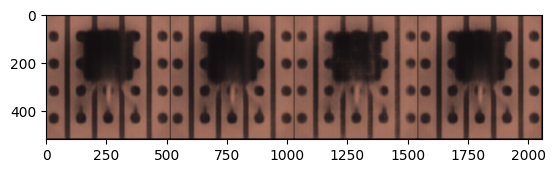


 EPOCH 15/50 	 train loss 0.04701186716556549 	 val loss 0.05189956724643707


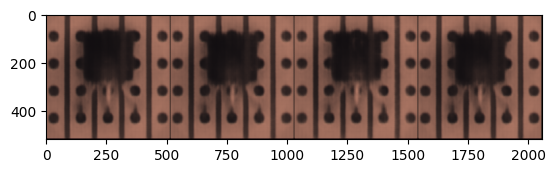


 EPOCH 16/50 	 train loss 0.046654827892780304 	 val loss 0.049364760518074036


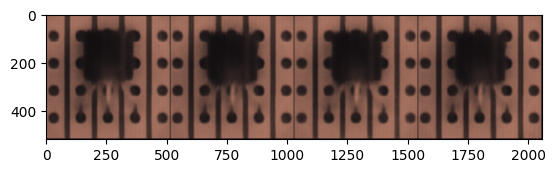


 EPOCH 17/50 	 train loss 0.04698672890663147 	 val loss 0.04937346279621124


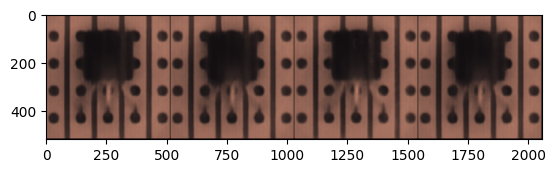


 EPOCH 18/50 	 train loss 0.046876825392246246 	 val loss 0.0513664186000824


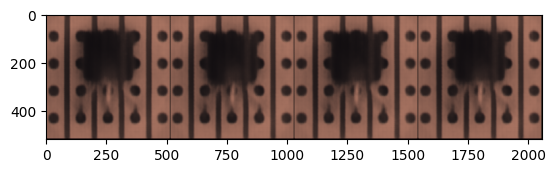


 EPOCH 19/50 	 train loss 0.046236682683229446 	 val loss 0.0487794429063797


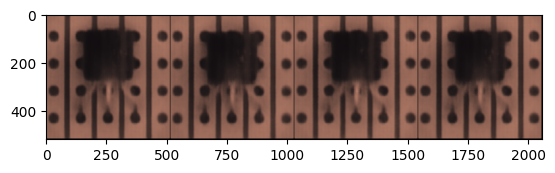


 EPOCH 20/50 	 train loss 0.04572221264243126 	 val loss 0.047141361981630325


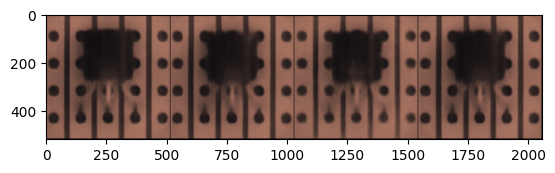


 EPOCH 21/50 	 train loss 0.04503581300377846 	 val loss 0.04842488840222359


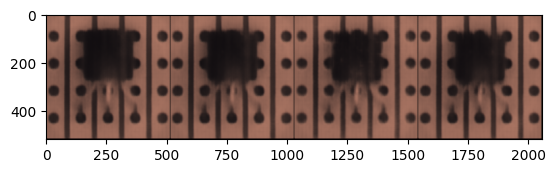


 EPOCH 22/50 	 train loss 0.04444596916437149 	 val loss 0.047703228890895844


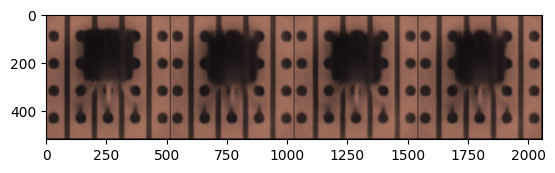


 EPOCH 23/50 	 train loss 0.04499262571334839 	 val loss 0.04796765744686127


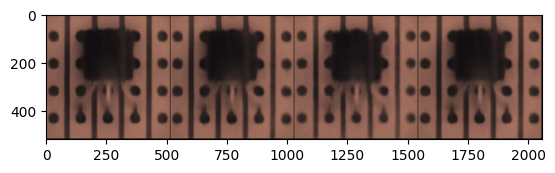


 EPOCH 24/50 	 train loss 0.04404348134994507 	 val loss 0.04755934327840805


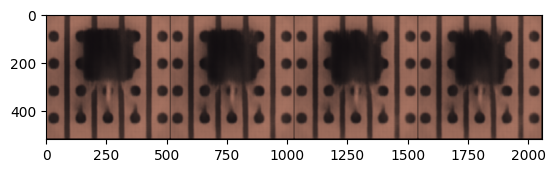


 EPOCH 25/50 	 train loss 0.044672489166259766 	 val loss 0.047827720642089844


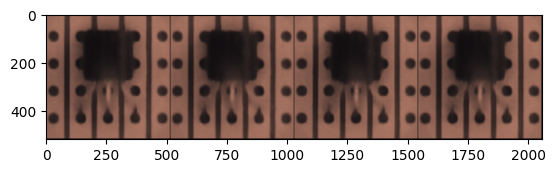


 EPOCH 26/50 	 train loss 0.04409588873386383 	 val loss 0.04708310589194298


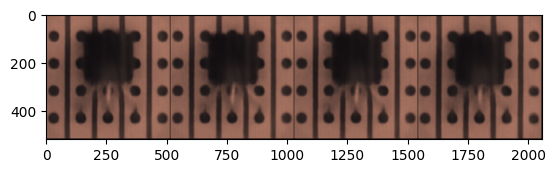


 EPOCH 27/50 	 train loss 0.04435093700885773 	 val loss 0.04590507224202156


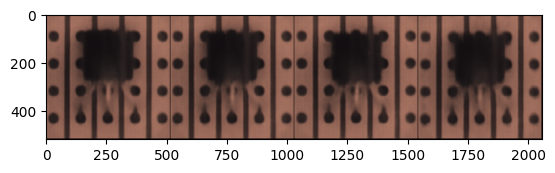


 EPOCH 28/50 	 train loss 0.043908990919589996 	 val loss 0.04525526985526085


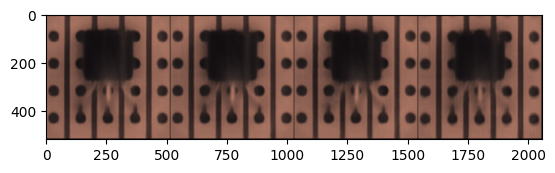


 EPOCH 29/50 	 train loss 0.04341006651520729 	 val loss 0.04572053998708725


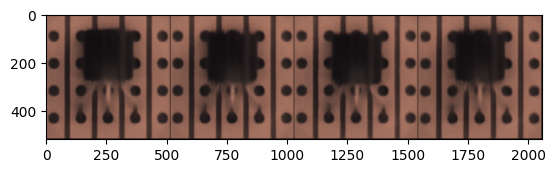


 EPOCH 30/50 	 train loss 0.04326660931110382 	 val loss 0.04754873365163803


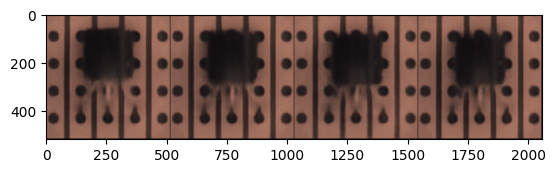


 EPOCH 31/50 	 train loss 0.043315913528203964 	 val loss 0.047415390610694885


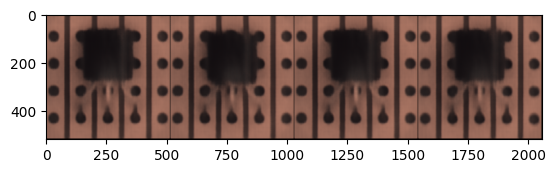


 EPOCH 32/50 	 train loss 0.04264458641409874 	 val loss 0.04813649505376816


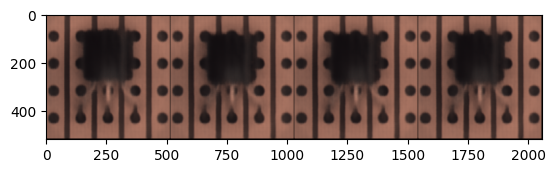


 EPOCH 33/50 	 train loss 0.042688146233558655 	 val loss 0.04562339931726456


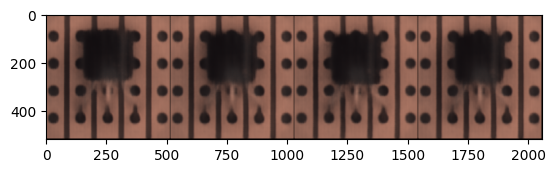


 EPOCH 34/50 	 train loss 0.04210231080651283 	 val loss 0.04558214545249939


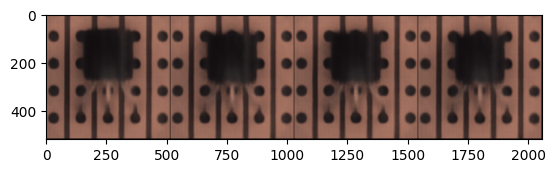


 EPOCH 35/50 	 train loss 0.04194730892777443 	 val loss 0.04412961006164551


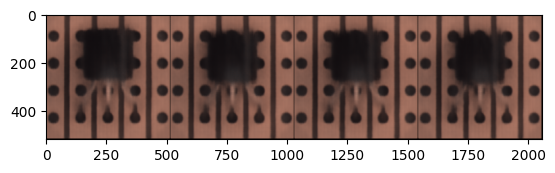


 EPOCH 36/50 	 train loss 0.04190754145383835 	 val loss 0.045083750039339066


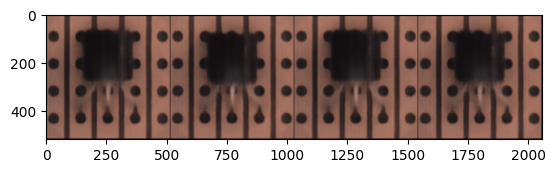


 EPOCH 37/50 	 train loss 0.04220009967684746 	 val loss 0.04650327190756798


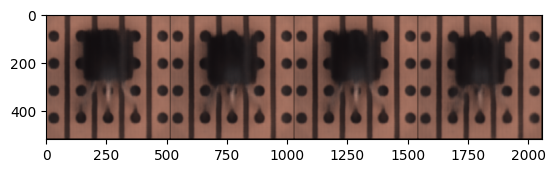


 EPOCH 38/50 	 train loss 0.042196810245513916 	 val loss 0.04544739052653313


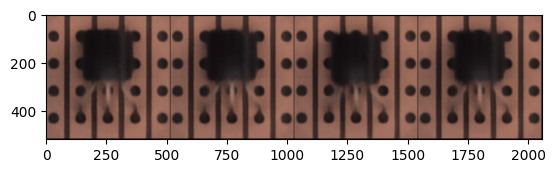


 EPOCH 39/50 	 train loss 0.042620688676834106 	 val loss 0.0446912907063961


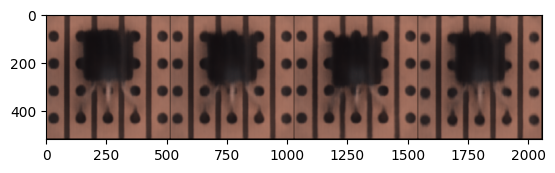


 EPOCH 40/50 	 train loss 0.04158259928226471 	 val loss 0.04428675025701523


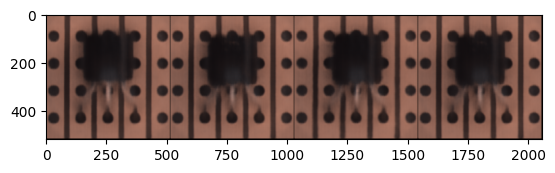


 EPOCH 41/50 	 train loss 0.04180360212922096 	 val loss 0.04460908845067024


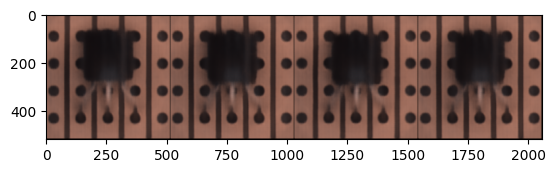


 EPOCH 42/50 	 train loss 0.0415964350104332 	 val loss 0.043669361621141434


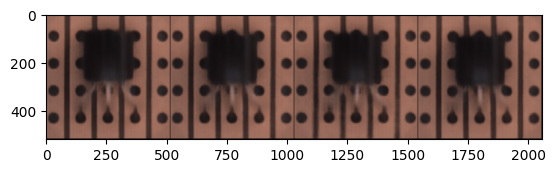


 EPOCH 43/50 	 train loss 0.041315093636512756 	 val loss 0.04288125038146973


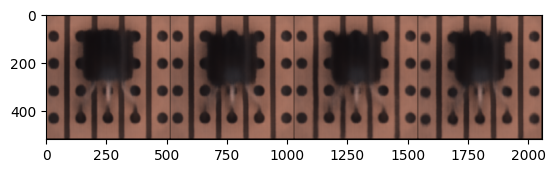


 EPOCH 44/50 	 train loss 0.0407976470887661 	 val loss 0.04354061186313629


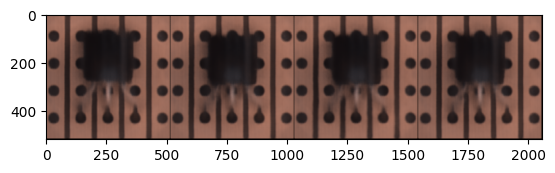


 EPOCH 45/50 	 train loss 0.04152156040072441 	 val loss 0.045044708997011185


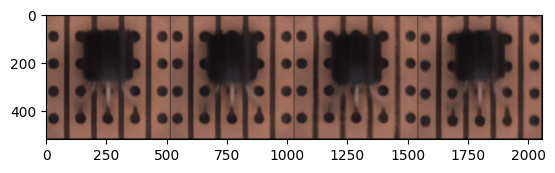


 EPOCH 46/50 	 train loss 0.04131781682372093 	 val loss 0.046167463064193726


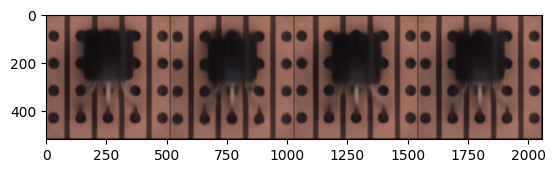


 EPOCH 47/50 	 train loss 0.04313705861568451 	 val loss 0.04600946977734566


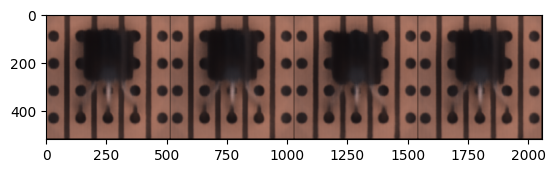


 EPOCH 48/50 	 train loss 0.042358845472335815 	 val loss 0.04315217211842537


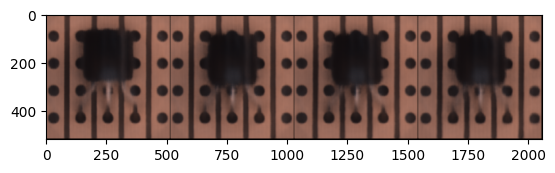


 EPOCH 49/50 	 train loss 0.04203145578503609 	 val loss 0.045735687017440796


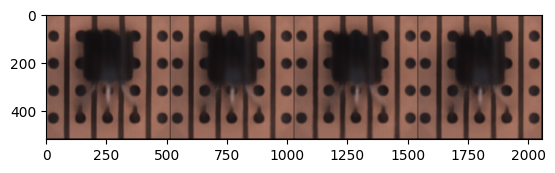


 EPOCH 50/50 	 train loss 0.04190162569284439 	 val loss 0.047721683979034424


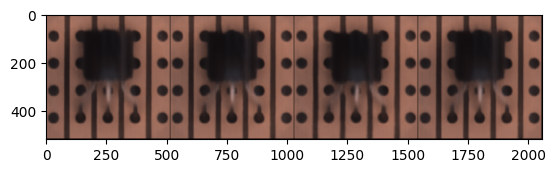

In [25]:
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(model,device,train_dataloader,loss,optim,scheduler)
   val_loss = test_epoch(model,device,val_dataloader,loss)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(model,n=10)

Save Model

In [27]:
torch.save(model.state_dict(), r'E:\Master Mechatronics\Projects\anomaly-detection\src\model\model')

Load Model

In [28]:
model.load_state_dict(torch.load(r'E:\Master Mechatronics\Projects\anomaly-detection\src\model\model'))
model.eval()

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True)

Temp Section do not delete

torch.Size([1, 3, 512, 512])


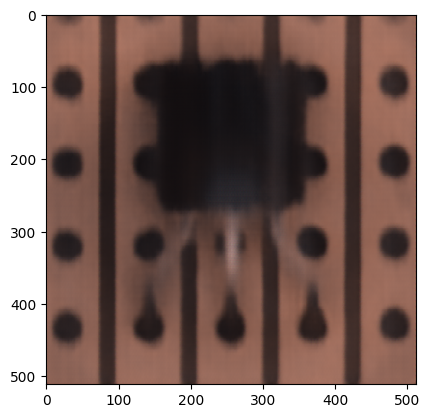

In [64]:
inputs = next(iter(test_dataloader))
inputs = inputs.to(device)
out = model(inputs)
print(out.shape)
out = out.cpu()
#print(out)
out = torchvision.utils.make_grid(out)
out =  out.detach()
imshow(out)

Loss Plot

In [20]:
plt.plot(diz_loss['train_loss'],label='train')
plt.plot(diz_loss['val_loss'],label='val')
plt.legend()
plt.show()

NameError: name 'diz_loss' is not defined

Latent Representation

In [30]:
train = []
val = []
test = []
data = []
with torch.no_grad():
        for image_batch in train_dataloader:
            image_batch = image_batch.to(device)
            decoded_data = model.encode(image_batch)
            train.append(decoded_data.cpu())
            data.append(decoded_data.cpu())
        for image_batch in val_dataloader:
            image_batch = image_batch.to(device)
            decoded_data = model.encode(image_batch)
            val.append(decoded_data.cpu())
            data.append(decoded_data.cpu())
        for image_batch in test_dataloader:
            image_batch = image_batch.to(device)
            decoded_data = model.encode(image_batch)
            test.append(decoded_data.cpu())
            data.append(decoded_data.cpu())
        train = torch.cat(train)
        val = torch.cat(val)
        test = torch.cat(test)
        data = torch.cat(data)


Zscore

In [62]:
zmean = test.mean(axis=0)
zstd = test.std(axis=0)


print(zmean, zstd)
for x in train:
    print(((x-zmean)/zstd>zstd))

tensor([-0.4688, -0.4479]) tensor([0.4051, 0.4049])
tensor([True, True])
tensor([True, True])
tensor([False,  True])
tensor([False,  True])
tensor([False,  True])
tensor([False,  True])
tensor([False,  True])
tensor([True, True])
tensor([True, True])
tensor([False,  True])
tensor([False,  True])
tensor([False, False])
tensor([False, False])
tensor([False, False])
tensor([False, False])
tensor([True, True])
tensor([False, False])
tensor([False, False])
tensor([True, True])
tensor([False,  True])
tensor([False,  True])
tensor([False, False])
tensor([ True, False])
tensor([False,  True])
tensor([ True, False])
tensor([True, True])
tensor([ True, False])
tensor([ True, False])
tensor([True, True])
tensor([True, True])
tensor([False, False])
tensor([False, False])
tensor([False,  True])
tensor([False,  True])
tensor([ True, False])
tensor([False,  True])
tensor([ True, False])
tensor([True, True])
tensor([False, False])
tensor([ True, False])
tensor([False,  True])
tensor([False,  True])
te

C:\Users\Nayan\AppData\Local\Temp\ipykernel_21852\3762618135.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(train[:, 0], train[:, 1],cmap='hot',label='train')
C:\Users\Nayan\AppData\Local\Temp\ipykernel_21852\3762618135.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(val[:, 0], val[:, 1],c='#FFA500', cmap='hot',label='val')
C:\Users\Nayan\AppData\Local\Temp\ipykernel_21852\3762618135.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(test[:, 0], test[:, 1],c='#00FF00', cmap='hot',label='test')


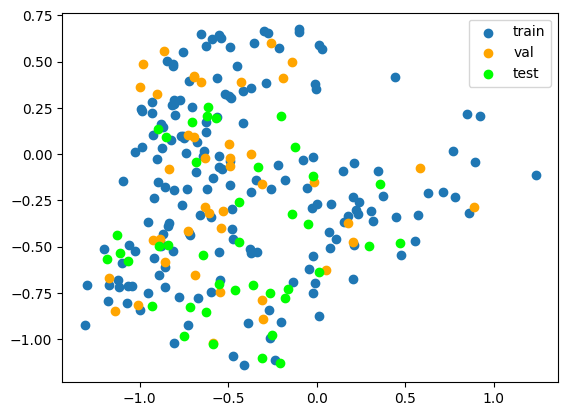

In [31]:

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(train[:, 0], train[:, 1],cmap='hot',label='train')
ax.scatter(val[:, 0], val[:, 1],c='#FFA500', cmap='hot',label='val')
ax.scatter(test[:, 0], test[:, 1],c='#00FF00', cmap='hot',label='test')

# ax = fig.add_subplot(projection='3d')
# ax.scatter(train[:, 0], train[:, 1], train[:, 2],cmap='hot',label='train')
# ax.scatter(val[:, 0], val[:, 1], val[:, 2],c='#FFA500', cmap='hot',label='val')
# ax.scatter(test[:, 0], test[:, 1], test[:, 2],c='#00FF00', cmap='hot',label='test')

# Display the plot
plt.legend()
plt.show()

In [32]:
from sklearn import cluster
kmeans = cluster.KMeans(init='k-means++',n_clusters=2, random_state=0).fit(data)

labels = kmeans.labels_
print(labels)
centroids = kmeans.cluster_centers_
print(centroids)
u_labels = np.unique(labels)

fig = plt.figure()
ax = fig.add_subplot()
for i in u_labels:
    ax.scatter(data[labels == i , 0] , data[labels == i , 1] , label = i)

ax.scatter(centroids[:,0] , centroids[:,1] , color = 'k')
plt.legend()
plt.show()



ModuleNotFoundError: No module named 'sklearn'

In [ ]:
# Kmeans prediction

kmeans.predict(train)

array([0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0], dtype=int32)

In [ ]:
# from sklearn.mixture import GaussianMixture
# gm = GaussianMixture(n_components=2, random_state=0).fit(data)
# print(gm.means_)
# print(gm.predict(train))

Encoder-Decoder Output Loss Histogram

In [42]:
model.eval()
clean = []
defect = []

for image_batch in train_dataloader:
    image_batch = image_batch.to(device)
    decoded_data = model(image_batch)
    mse = loss(decoded_data, image_batch).detach()
    clean.append(mse.cpu().detach().item())

for image_batch in test_dataloader:
    image_batch = image_batch.to(device)
    decoded_data = model(image_batch)
    mse = loss(decoded_data, image_batch).detach()
    defect.append(mse.cpu().detach().item())





In [43]:
print(len(clean))

171


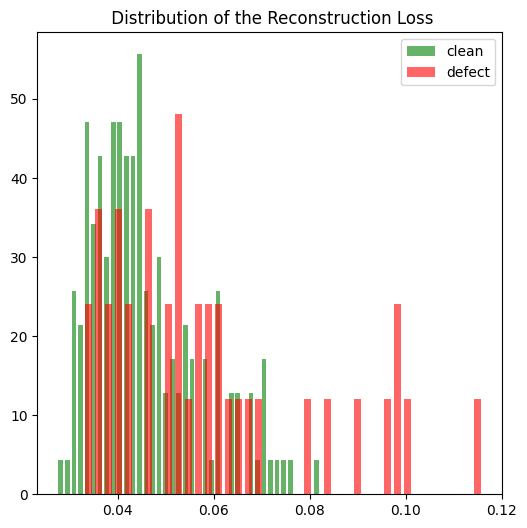

[0.0428377166390419, 0.03701750189065933, 0.04337693750858307, 0.04437961429357529, 0.054101891815662384, 0.039392709732055664, 0.04095207527279854, 0.041719745844602585, 0.03604862838983536, 0.056013040244579315, 0.033657003194093704, 0.04586045444011688, 0.04858211427927017, 0.07291295379400253, 0.05034935101866722, 0.051033537834882736, 0.034022875130176544, 0.04033035784959793, 0.04775809496641159, 0.06358850002288818, 0.04641883820295334, 0.0434621199965477, 0.03440482169389725, 0.06480924040079117, 0.05358625575900078, 0.030734676867723465, 0.06072818487882614, 0.035645052790641785, 0.05786661431193352, 0.04405131936073303, 0.07055516541004181, 0.051233477890491486, 0.04269006475806236, 0.03709021210670471, 0.03543384000658989, 0.0598578155040741, 0.03322390839457512, 0.038677990436553955, 0.046617891639471054, 0.04813919588923454, 0.05256755277514458, 0.044492434710264206, 0.04554402828216553, 0.04041574150323868, 0.03345426172018051, 0.03670240193605423, 0.04995829612016678, 0.

In [48]:
fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean, bins=40, density=True, label="clean", alpha=.6, color="green", rwidth=0.7)
ax.hist(defect, bins=40, density=True, label="defect", alpha=.6, color="red", rwidth=0.7)

plt.title(" Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

print(clean, defect)